In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import plotly.graph_objects as go
from joblib import Parallel, delayed
from scipy.optimize import linprog
from collections import Counter

# Example Graph (from lecture 6)

This uses second example from Lecture 6 and implement LP solution. 

Shortest Path: [('b', 'e'), ('f', 'b')]
Total Distance: 4.47213595499958


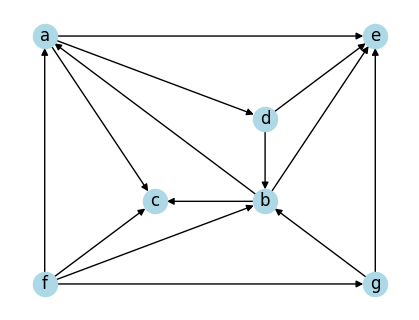

In [2]:
nodes = ['a','b','c','d','e','f','g']
coordinates = {'a':(0,3),'b':(2,1),'c':(1,1),'d':(2,2),'e':(3,3),'f':(0,0),'g':(3,0)}
edges = [('a','c'),('a','d'),('a','e'),('b','a'),('b','c'),('b','e'),('d','b'),
         ('d','e'),('f','a'),('f','b'),('f','c'),('f','g'),('g','b'),('g','e')]

G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
plt.figure(figsize=(4,3))
nx.draw(G,pos=coordinates,with_labels=True,node_color='lightblue')

edge_weights = {}
for u, v in edges:
    dist = np.linalg.norm(np.array(coordinates[u]) - np.array(coordinates[v]))
    edge_weights[(u, v)] = dist

edge_list = list(edge_weights.keys())
n_edges = len(edge_list)

c = [edge_weights[e] for e in edge_list]

A_eq = []
b_eq = []

for node in nodes:
    row = [0] * n_edges
    for i, (u, v) in enumerate(edge_list):
        if u == node:
            row[i] = 1 
        if v == node:
            row[i] = -1  
    
    if node == 'f':  
        b_eq.append(1)
    elif node == 'e':  
        b_eq.append(-1)
    else:
        b_eq.append(0)  
    A_eq.append(row)

bounds = [(0, 1)] * n_edges

res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

if res.success:
    selected_edges = [edge_list[i] for i in range(n_edges) if res.x[i] > 0.5]
    print("Shortest Path:", selected_edges)
    print("Total Distance:", res.fun)
else:
    print("No solution found.")

# Example Graph (from lecture 6)

This uses Vacnouver Bus Station example from Lecture 6 and implement LP solution. 

Shortest path from Downtown to MarineBoundary: 0 -> 3 -> 10 -> 13 -> 19 -> 24
Total distance: 0.14167586787904146


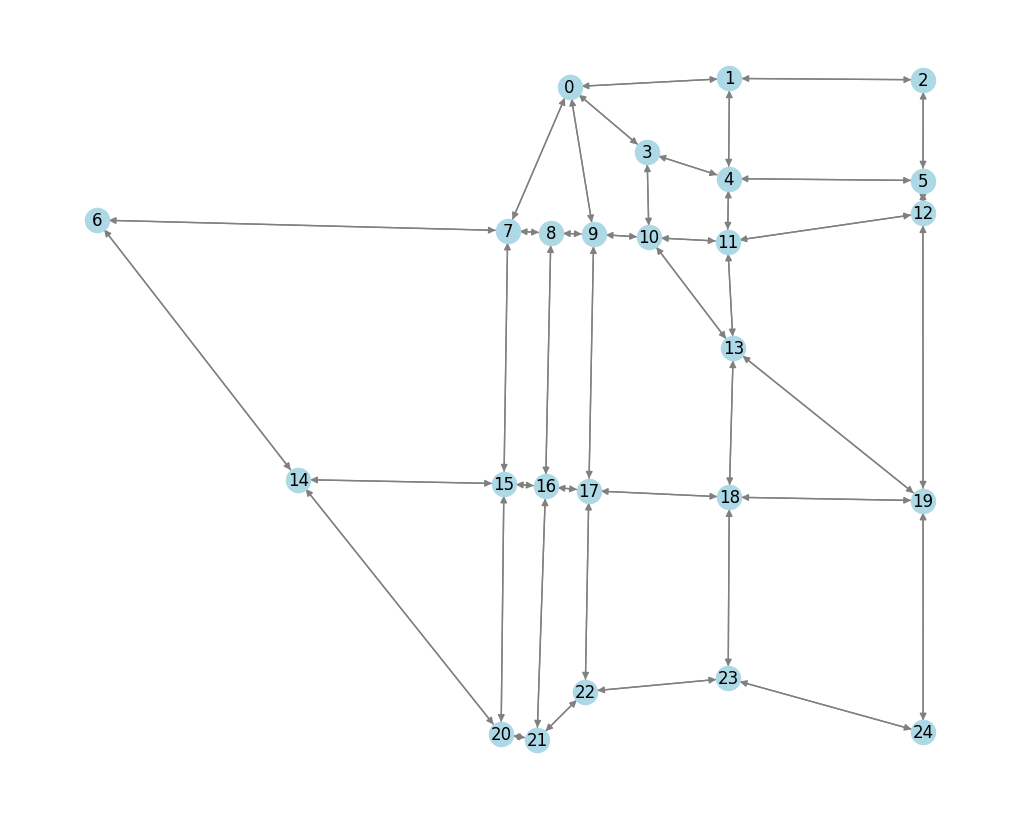

In [3]:
stations_file = "VancouverBus/stations.csv"
routes_file = "VancouverBus/routes.csv"

nodes = pd.read_csv(stations_file, index_col=0)
edges = pd.read_csv(routes_file)

G = nx.DiGraph()
G.add_nodes_from(nodes.index)

def euclidean_distance(node1, node2):
    x1, y1 = nodes.loc[node1, "x"], nodes.loc[node1, "y"]
    x2, y2 = nodes.loc[node2, "x"], nodes.loc[node2, "y"]
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

for i in edges.index:
    source, target = edges.iloc[i, 0], edges.iloc[i, 1]
    if source in nodes.index and target in nodes.index:
        distance = euclidean_distance(source, target)
        G.add_edge(source, target, weight=distance)

source_station = 0  # Downtown
target_station = 24  # MarineBoundary

num_edges = len(G.edges)
edges_list = list(G.edges)
edge_to_index = {edge: i for i, edge in enumerate(edges_list)}

c = np.array([G[u][v]['weight'] for u, v in edges_list])

A_eq = np.zeros((len(G.nodes), num_edges))
b_eq = np.zeros(len(G.nodes))

for i, node in enumerate(G.nodes):
    for edge in edges_list:
        if edge[0] == node:
            A_eq[i, edge_to_index[edge]] = 1  
        if edge[1] == node:
            A_eq[i, edge_to_index[edge]] = -1 
    
    if node == source_station:
        b_eq[i] = 1 
    elif node == target_station:
        b_eq[i] = -1 

x_bounds = [(0, 1)] * num_edges

res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=x_bounds, method='highs')

if res.success:
    selected_edges = [edges_list[i] for i in range(num_edges) if res.x[i] > 0.5]
    shortest_path = [source_station] + [e[1] for e in selected_edges]
    total_distance = sum(G[u][v]['weight'] for u, v in selected_edges)
    print("Shortest path from Downtown to MarineBoundary:", " -> ".join(map(str, shortest_path)))
    print("Total distance:", total_distance)
else:
    print("No feasible path found.")

plt.figure(figsize=(10, 8))
coordinates = {i: (nodes.loc[i, "x"], nodes.loc[i, "y"]) for i in nodes.index}
nx.draw(G, pos=coordinates, with_labels=True, node_color='lightblue', edge_color='gray')
plt.show()

In [4]:
def shortest_path_lp(source, target):
    global G  # Assume G is the directed graph of bus stations

    nodes = list(G.nodes)
    num_nodes = len(nodes)
    edges = list(G.edges)
    num_edges = len(edges)
    
    # Incidence matrix for LP formulation
    A_eq = np.zeros((num_nodes, num_edges))

    for j, (u, v) in enumerate(edges):
        A_eq[nodes.index(u), j] = 1  # Outgoing edge
        A_eq[nodes.index(v), j] = -1  # Incoming edge

    # Flow vector b: Source = 1, Target = -1
    b_eq = np.zeros(num_nodes)
    b_eq[nodes.index(source)] = 1
    b_eq[nodes.index(target)] = -1

    # Cost function: Edge weights (distances)
    c = np.array([G[u][v].get("weight", 1) for u, v in edges])  # Default weight = 1 if missing

    # Solve LP
    result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=(0, 1), method="highs")

    # Check if LP succeeded
    if result.success:
        # Extract the edges used in the shortest path
        selected_edges = [edges[i] for i, x in enumerate(result.x) if x > 0.5]

        # Reconstruct the path by ordering the nodes
        path = [source]
        while path[-1] != target:
            for u, v in selected_edges:
                if u == path[-1] and v not in path:
                    path.append(v)
                    break

        return path
    else:
        print(f"LP Failed: No path found from {source} to {target}")
        return None


In [5]:
shortest_path_lp(0, 24)

[0, np.int64(3), np.int64(10), np.int64(13), np.int64(19), np.int64(24)]

In [6]:
def heuristic_meeting_point(station_list):
    visited_nodes = []  

    # Compute shortest paths between all pairs of stations
    for i in range(len(station_list)):
        for j in range(i + 1, len(station_list)):  # Avoid duplicate pairs
            path = shortest_path_lp(station_list[i], station_list[j])
            if path:
                visited_nodes.extend(path)  # Add nodes from this path

    # Count frequency of each visited node
    node_counts = Counter(visited_nodes)

    # Find the most frequently visited node
    heuristic_middle = max(node_counts, key=node_counts.get)

    print("Most visited node (heuristic meeting point):", heuristic_middle)
    return node_counts


In [7]:
heuristic_meeting_point([24, 23, 21, 6, 5, 15])

Most visited node (heuristic meeting point): 23


Counter({np.int64(23): 8,
         np.int64(21): 7,
         24: 5,
         np.int64(22): 5,
         np.int64(6): 5,
         np.int64(12): 5,
         np.int64(5): 5,
         np.int64(15): 5,
         np.int64(20): 4,
         np.int64(14): 4,
         np.int64(11): 4,
         np.int64(18): 3,
         np.int64(17): 3,
         np.int64(16): 3,
         np.int64(9): 3,
         np.int64(10): 3,
         np.int64(8): 2,
         np.int64(19): 1,
         np.int64(13): 1,
         np.int64(7): 1})